In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

In [2]:
translation_dict = {
    'native-tls-hw-supp': 'Native TLS HW supp',
    'native-tls': 'Native TLS no HW supp',
    'native': 'Native (no TLS)',
    'wasm': 'WASM (no TLS)',
    'wasm-tls': 'WASM TLS',
    'sgx': 'WASM SGX (no TLS)',
    'sgx-tls': 'WASM SGX TLS',
    'qos0': 'QoS 0',
    'qos1': 'QoS 1',
    'qos2': 'QoS 2',
    'expected_delivered': 'Expected delivered messages / s',
    'delivered_messages': 'Delivered messages / s',
    'reliability': 'Delivery rate (%)',
    'latency': 'Latency (s)',
    'throughput': 'Throughput (Messages /s) [at min 95 % reliability]',
    'timestamp' : 'Time [s]',
    'messages' : 'Messages / s',
}

cases = ['native-tls', 'native-tls-hw-supp', 'native', 'wasm', 'wasm-tls', 'sgx', 'sgx-tls']
cases_tls = ['native-tls', 'wasm-tls', 'sgx-tls']
cases_no_tls = ['native', 'wasm', 'sgx']
cases_native = ['native-tls', 'native-tls-hw-supp', 'native']

cases = cases_tls

machine = 'grassen-1'

In [3]:
number_publishers = 1
number_subscribers = 256
message_dict = {}
for case in cases:
    publisher_df = pd.DataFrame()
    for i in range(number_publishers):
        df = pd.read_csv('data/' + machine + '/results_' + case + '/' + str(i) + '.csv', sep = ';')
        publisher_df = pd.concat([publisher_df, df])
    
    subscriber_df = pd.DataFrame()
    for i in range(number_subscribers):
        df = pd.read_csv('data/' + machine + '/results_' + case + '/' + str(i + number_publishers) + '.csv', sep = ';')
        subscriber_df = pd.concat([subscriber_df, df])
    
    # only receive events
    subscriber_df = subscriber_df[subscriber_df['event'] == 9]
    subscriber_df = subscriber_df.sort_values(by=['timestamp']).rename(columns={'timestamp': 'timestamp_receive'})
    subscriber_df = subscriber_df.drop(columns=['event'])
    # only send events
    publisher_df = publisher_df[publisher_df['event'] == 3]
    publisher_df = publisher_df.sort_values(by=['timestamp']).rename(columns={'timestamp': 'timestamp_send'})
    publisher_df = publisher_df.drop(columns=['event'])

    print('Case: ' + case)
    print('Number of received messages: ' + str(len(subscriber_df)))
    print('Number of sent messages: ' + str(len(publisher_df)))
    print('Number of lost messages: ' + str(len(publisher_df) - len(subscriber_df)))
    print('\n')

    df = pd.merge(subscriber_df, publisher_df, on='payload', how='outer')
    df = df.drop(columns=['payload'])

    df['latency'] = df['timestamp_receive'] - df['timestamp_send']
    
    message_dict[case] = df


Case: native-tls
Number of received messages: 13449
Number of sent messages: 13450
Number of lost messages: 1


Case: wasm-tls
Number of received messages: 13448
Number of sent messages: 13449
Number of lost messages: 1


Case: sgx-tls
Number of received messages: 13449
Number of sent messages: 13450
Number of lost messages: 1




In [4]:
# if directory export does not exist, create it
if not os.path.exists('export'):
    os.makedirs('export')
if not os.path.exists('export/' + machine):
    os.makedirs('export/' + machine)
    
f = open('export/' + machine + '/readme.txt', 'w')
f.write('This folder contains the results of the case "subscriber scaling".\n')
f.write('In this case, the message rate as well as the number of publishers is fixed.\n')
f.write('The number of subscribers is scaled from 1 to 256 at an exponential scale (2^i).\n')
f.write('Every case runs for 60 seconds. Afterwards the number is increased. Note, that the broker is not restarted inbetween.\n\n')
f.write('The parameters used are as follows:\n')
f.write('  - Message rate: 25 / s\n')
f.write('  - Number of publishers: ' + str(number_publishers) + '\n')
f.write('  - Size of Payload: 16Kb random data\n')
f.write('  - QoS: 0\n')
f.write('\n')
f.write('Note: The subscribers subscribe to a shared topic, i.e. every message is only received by one subscriber.\n')
f.close()

In [5]:
bin_dict = {}
for case in cases:
    df = pd.read_csv('data/' + machine + '/results_' + case + '/orchestrator.csv', sep = ';')
    # iterate through df
    bins = pd.DataFrame(columns = ['bin', 'start', 'end', 'duration'])
    for index, row in df.iterrows():
        # add new bin
        bins = bins.append({'bin': row['payload'], 'start': row['timestamp']}, ignore_index = True)

        # check if bin is already in bins
        if index > 0:
            # update end time
            bins.iloc[index-1]['end'] = row['timestamp']
            # update duration
            bins.iloc[index-1]['duration'] = bins.iloc[index-1]['end'] - bins.iloc[index-1]['start'] 
        
        if index == len(df) - 1:
            bins.iloc[index]['end'] = message_dict[case]['timestamp_receive'].max()
            bins.iloc[index]['duration'] = bins.iloc[index]['end'] - bins.iloc[index]['start'] 
        
    bin_dict[case] = bins

In [6]:
# assign every message to one of the bins
for case in cases:
    result_df = pd.DataFrame()
    message_df = message_dict[case]
    message_df['nb_subscribers'] = 0
    bin_df = bin_dict[case]
    for index, row in bin_df.iterrows():
        # get all messages which have send timestamp between start and end
        start = row['start']
        end = row['end']
        message_df.loc[(message_df['timestamp_send'] >= start) & (message_df['timestamp_send'] < end), 'nb_subscribers'] = row['bin']

    message_df = message_df[message_df['nb_subscribers'] != 0]
    message_dict[case] = message_df

In [7]:
message_latency = pd.DataFrame()
for case in cases:
    df = message_dict[case]
    df['case'] = case
    message_latency = pd.concat([message_latency, df])

message_latency.to_csv('export/' + machine + '/message_latency.csv')

# write a description file for the export
f = open('export/' + machine + '/message_latency.txt', 'w')
f.write('This file contains for every message the observed latency.\n')
f.write('The first column is a index without any further meaning\n')
f.write('the other columns are as described below:\n\n')
for col in message_latency.columns:
    if(col == 'case'):
        f.write(col + ': case of the measurement\n')
    if(col == 'latency'):
        f.write(col + ': end to end latency for this given message in ms\n')
    if(col == 'nb_subscribers'):
        f.write(col + ': the number of subscribers that consumed all messages in a shared way (i.e. only 1 receives a message)\n')
    if(col == 'timestamp_send'):
        f.write(col + ': the timestamp of when the publisher sent the message\n')
    if(col == 'timestamp_receive'):
        f.write(col + ': the timestamp of when the subscriber received the message\n')

f.write('\n\n')
f.write('The following cases were measured:\n')
for case in cases:
    f.write(case + ': ' + translation_dict[case] +'\n')

f.close()

In [8]:
latency_per_subscribers = pd.DataFrame()
for case in cases:
    messages = message_dict[case]
    df = messages.groupby('nb_subscribers').mean()
    df = df.drop(columns=['timestamp_send', 'timestamp_receive'])
    df['case'] = case
    df = df.reset_index()
    latency_per_subscribers = pd.concat([latency_per_subscribers, df])

In [9]:
# if directory export does not exist, create it
if not os.path.exists('export'):
    os.makedirs('export')
if not os.path.exists('export/' + machine):
    os.makedirs('export/' + machine)
latency_per_subscribers.to_csv('export/' + machine + '/latency_per_nb_subscribers.csv')

# write a description file for the export
f = open('export/' + machine + '/latency_per_nb_subscribers.txt', 'w')
f.write('This file contains the average latency per numbers of subscribers and case.\n')
f.write('The first column is a index without any further meaning\n')
f.write('the other columns are as described below:\n\n')
for col in latency_per_subscribers.columns:
    if(col == 'case'):
        f.write(col + ': case of the measurement\n')
    if(col == 'latency'):
        f.write(col + ': mean latency of all single message latencies of this case and number of subscribers\n')
    if(col == 'nb_subscribers'):
        f.write(col + ': the number of subscribers that consumed all messages in a shared way (i.e. only 1 receives a message)\n')

f.write('\n\n')
f.write('The following cases were measured:\n')
for case in cases:
    f.write(case + ': ' + translation_dict[case] +'\n')

f.close()

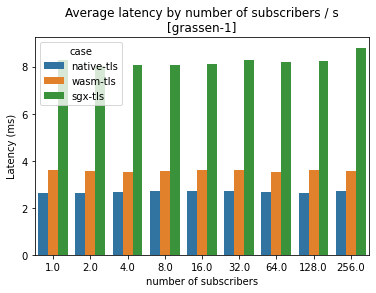

In [10]:
df = latency_per_subscribers.rename(columns={'latency': 'Latency (ms)', 'nb_subscribers': 'number of subscribers'})
sns.barplot(data=df, x='number of subscribers', y='Latency (ms)', hue='case')
plt.title('Average latency by number of subscribers / s\n['+ machine + ']')
plt.xlabel('number of subscribers')
plt.ylabel('Latency (ms)')

plt.savefig('export/' + machine + '/latency_per_nb_subscribers.png', dpi=300, bbox_inches='tight', transparent = False)